<a href="https://colab.research.google.com/github/44REAM/RA-Medphys/blob/main/Class3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Particle constant

https://docs.scipy.org/doc/scipy/reference/constants.html

In [1]:
import scipy.constants as constants

In [ ]:
# electron mass constant (kg)
constants.m_e

9.1093837015e-31

In [ ]:
# elementary charge
constants.e

1.602176634e-19

In [ ]:
# elementary charge: charge for single proton (value, unit, uncertainty)
constants.physical_constants['elementary charge']

(1.602176634e-19, 'C', 0.0)

In [ ]:
# 1 AMU
constants.physical_constants['atomic mass unit-kilogram relationship']

(1.6605390666e-27, 'kg', 5e-37)

# Dose calculation algorithm

References

*   https://aapm.onlinelibrary.wiley.com/doi/abs/10.1118/1.3301618
*   https://aapm.org/meetings/amos2/pdf/49-14369-44066-15.pdf
*   https://www.mdpi.com/2076-3417/11/15/6806
*   https://oncologymedicalphysics.com/dose-calculation-algorithms/



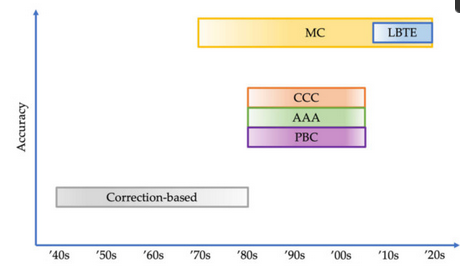

## Correction-based

## Model-based

*   Monte carlo (MC) most accurated
*   Kernel Based Algorithms
    *   Pencil Beam Convolution (PBS)
    *   Collapsed Cone Convolution (CCC)
    *   Analytical Anisotropic Algorithm (AAA)








## Kernel-based algorithm

$$TERMA * Kernel = Dose$$


TERMA คือ energy ที่ primary photon ปล่อยออกมาเมื่อ interaction กับ medium

Kernel คือ dose spread function ซึ่งอธิบายถึง energy ที่ปล่อยออกมาจาก secondary particles

Convolution animation: https://medium.com/theleanprogrammer/2-dimensional-convolution-189abb174d92

### Pencil beam kernel

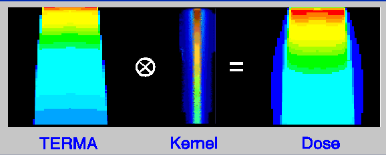

### Point kernel (estimate from MC)

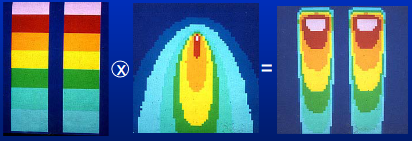

### Total energy released per mass (TERMA)

Radiation beam are polyenergetic

$$TERMA(r) = \int_0^E \frac{\mu}{\rho}(E, r)Ψ(E,r) dE$$

$\frac{\mu}{\rho}(r)$ is mass attenuation coefficients

$Ψ(E,r)$ is primary energy fluence

For simplicity, I treat radiation beam as monoenergetic

$$TERMA(r) =  \frac{\mu}{\rho}(E, r)Ψ(E,r) $$

primary energy fluence is given by

$$ Ψ(E,r) = Ψ(E,r_0)(\frac{r_0}{r})^2 e^{-L(E,r)} $$

where $Ψ(E,r_0)$ is primary energy fluence in air at some standard distance ($r_0$) and $L(E,r)$ is radiological length that given by

$$L(E,r) = \int  \rho(E) \frac{\mu}{\rho}(E, r) dr$$

$$L(E,r) = \sum  \rho(E) \frac{\mu}{\rho}(E, r) × r$$

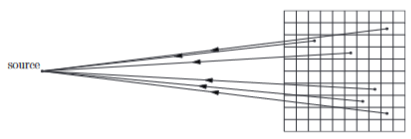

### Calculation distance ($r$) from source



In [2]:
import numpy as np

#### สร้าง source

In [3]:
# สร้าง source ของเราขึ้นมา
# ให้อยู่ที่จุด (0, -100) unit เช่น ที่แกน x 0cm แกน y -100cm
source_location = np.array([0,-100])

# ให้ ray ที่ฉายออกไปเป็นมุม 60 องศา
source_angle = 60

# ให้ ray ที่ฉายออกไปมีทิศทางขึ้น
source_direction = np.array([0,1])


#### สร้าง medium

ต้องรู้อะไรบ้าง

1.   ตำแหน่งของ medium
2.   grid size ของ medium
3.   ขนาดของ medium
4.   voxel shape



In [13]:
# สร้าง medium ของเราขึ้นมา assume ว่าเป็นน้ำทั้งหมด
# ให้ voxel shape 50*50
# medium ให้มี unit เป็น mass attennuation coefficient
medium = np.ones((50,50))

# ให้ที่ index (0,0) ของ numpy array อยู่ที่จุด (0,0) unit
medium_start_location = np.array([0,0])

# grid size ของ medium
medium_spacing = np.array([2, 3])

# ขนาดของ medium in unit
print("medium.shape * medium_spacing = physical size",medium.shape * medium_spacing)

# ที่ index ใน numpy (0,0) อยู่ใน physical space ที่ unit เท่าไร?
def point(x,y):
    return np.array([x,y])
medium_start_location + point(0,0)

# ที่ index ใน numpy (12,10) อยู่ใน physical space ที่ unit เท่าไร?
print("physical location = ",medium_start_location + point(12,10)*medium_spacing)

def physical_location(x,y):
    return medium_start_location + point(x,y)*medium_spacing

physical_location(12,12)

medium.shape * medium_spacing = physical size [100 150]
physical location =  [24 30]


array([24, 36])

**ตัวอย่างล่าง**

voxel shape เป็น (7,6)

ขนาดของ medium เป็น 140*180

ตำแหน่งที่มุมซ้ายล่างอยู่ที่ (60,70)

Grid size (spacing) เป็น (20, 30)

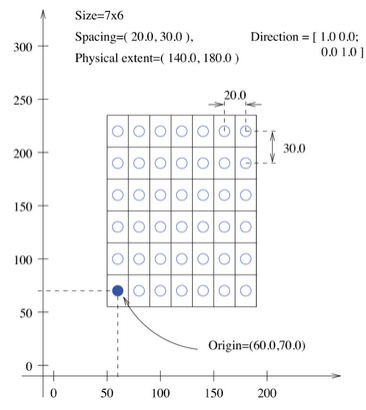

ref image: https://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/03_Image_Details.html

In [35]:
def physical_to_index(x_physical,y_physical):
    # บวกขนาด block เข้าไปครึ่งนึงเพื่อให้เวลาปัดเศษจะกลับมาเป็น index ที่ถูกต้อง
    new_point = point(x_physical,y_physical)+ medium_spacing/2

    index = (new_point- medium_start_location)/medium_spacing

    # ปัดเศษลง
    index = np.floor(index)

    # เปลี่ยนให้เป็น integer
    return index.astype(int)


### หา radiological length $L(E,r)$ (Ray tracing)

Radiological length

$$L(E,r) = \sum  ρ (E) \frac{\mu}{\rho}(E, r) × r$$

#### หา r ในแต่ละจุด


In [20]:
# vector ที่เริ่มจาก source ไปหาจุดที่สนใจได้แก่
myvector = physical_location(-10,-200) - source_location
print(myvector)

# ขนาด vector
vec_size = np.linalg.norm(myvector) # L2 norm
# vec_size = np.sqrt(np.sum(myvector**2))
print("vec size = distance source to physical location",vec_size)

# unit vector
# https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html
myunit_vector = myvector/vec_size
print(myunit_vector)

# หา มุมจาก source ไปยังจุดที่สนใจ
cos_theta = source_direction.dot(myunit_vector)
theta = np.arccos(cos_theta) # radian
print(theta/np.pi*180)

[ -20 -500]
vec size = distance source to physical location 500.39984012787215
[-0.03996804 -0.99920096]
177.7093899573614


$$cos(θ) = \frac{A ⋅ B}{|A||B|} $$

In [22]:
# source to physical location
def vector_source_to_index(x,y):
    myvector = physical_location(x, y) - source_location
    return myvector

# สร้าง function
def index_to_source_angle(x, y):
    myvector = vector_source_to_index(x,y)
    myunit_vector = myvector/np.linalg.norm(myvector)
    cos_theta = source_direction.dot(myunit_vector)
    theta = np.arccos(cos_theta) # radian
    return theta/np.pi*180

In [27]:
r_matrix = []
for x in range(medium.shape[0]):
    for y in range(medium.shape[1]):

        vector = vector_source_to_index(x,y)
        vec_size = np.linalg.norm(vector)
        r_matrix.append(vec_size)


In [31]:
r_matrix = np.array(r_matrix)
r_matrix = r_matrix.reshape(medium.shape)

In [32]:
r_matrix.shape

(50, 50)

#### สร้าง ray (ray tracing)

Ray tracing algorithm เป็น technique ที่จะ simulate path of radiation จาก source ไปถึงจุดที่เราสนใจ ในที่นี้จะเป็นตั้งแต่แหล่งกำเนิด radiation ไปถึง medium ของเรา

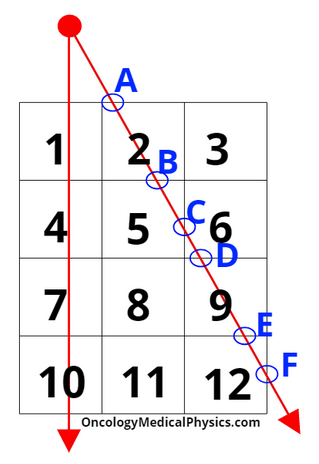

ref: https://oncologymedicalphysics.com/dose-calculation-algorithms/

$$L(E,r) = \sum  ρ (E) \frac{\mu}{\rho}(E, r) × r$$

In [36]:
# ให้เริ่มที่ source location
current_location = source_location

# current length
current_length = np.linalg.norm(current_location-source_location)

# direction ของ physical location ที่ต้องการ
vector = vector_source_to_index(10,15)
vector_size = np.linalg.norm(vector)
unit_vector = vector/vector_size

radiological_length = 0
# r ในสมการ
step_size = 0.5

# ขอให้ ρ(E) เป็น 1
rho_e = 1

# เราจะ move current location ของเราไปเรื่อยๆจนกว่า
# current location เราจะเกิน physical location ที่ต้องการไป
while current_length < vector_size:
    current_index = physical_to_index(current_location[0], current_location[1])

    # หา radiological length
    radiological_length = radiological_length + step_size*medium[current_index[0], current_index[1]] * rho_e

    # update current location
    current_location = current_location+unit_vector*step_size

    # update current length
    current_length = np.linalg.norm(current_location-source_location)



In [40]:
# เปลี่ยนข้างบนให้อยู่ในรูป function
def ray_tracing(x, y, step_size = 0.5):
    # ให้เริ่มที่ source location
    current_location = source_location

    # current length
    current_length = np.linalg.norm(current_location-source_location)

    # direction ของ physical location ที่ต้องการ
    vector = vector_source_to_index(x,y)
    vector_size = np.linalg.norm(vector)
    unit_vector = vector/vector_size

    radiological_length = 0

    rho_e = 1

    # เราจะ move current location ของเราไปเรื่อยๆจนกว่า
    # current location เราจะเกิน physical location ที่ต้องการไป
    while current_length < vector_size:
        current_index = physical_to_index(current_location[0], current_location[1])

        # ขอให้ ρ(E) เป็น 1
        radiological_length = radiological_length + step_size*medium[current_index[0], current_index[1]] * rho_e

        # update current location
        current_location = current_location+unit_vector*step_size

        # update current length
        current_length = np.linalg.norm(current_location-source_location)
    return radiological_length

In [41]:
radiological_matrix = []
# for every location in medium
for x in range(medium.shape[0]):
    for y in range(medium.shape[1]):

        # calculation angle
        angle = index_to_source_angle(x,y)

        radiological_length = 0
        # ถ้าทำมุมน้อยกว่า 60 ให้เริ่ม ray trace
        if angle<source_angle/2:
            radiological_length = ray_tracing(x, y)
        radiological_matrix.append(radiological_length)

In [42]:

radiological_matrix = np.array(radiological_matrix)
radiological_matrix = radiological_matrix.reshape(medium.shape)

In [43]:
radiological_matrix

array([[100. , 103. , 106. , ..., 241. , 244. , 247. ],
       [100.5, 103.5, 106.5, ..., 241.5, 244.5, 247.5],
       [100.5, 103.5, 106.5, ..., 241.5, 244.5, 247.5],
       ...,
       [  0. ,   0. ,   0. , ..., 259. , 261.5, 264.5],
       [  0. ,   0. ,   0. , ..., 259.5, 262.5, 265.5],
       [  0. ,   0. ,   0. , ..., 260.5, 263. , 266. ]])

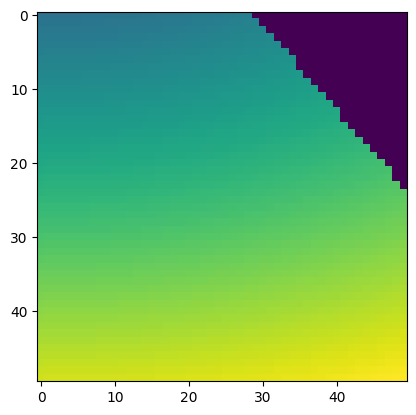

In [46]:
import matplotlib.pyplot as plt
plt.imshow(radiological_matrix.T)

#### Calculate energy influence

$$ Ψ(E,r) = Ψ(E,r_0)(\frac{r_0}{r})^2 e^{-L(E,r)} $$

In [49]:
angle_matrix = []
for x in range(medium.shape[0]):
    for y in range(medium.shape[1]):

        angle = index_to_source_angle(x,y)
        angle_matrix.append(angle)
angle_matrix = np.array(angle_matrix)
angle_matrix = angle_matrix.reshape(medium.shape)

In [51]:
psi_0 = 1

r_0 = 100

# เนื่องจากไม่ได้ใช้ตัวเลข constant จริงๆผมขอหารด้วยค่าคงตัว
divi = 50

psi = psi_0 * (r_0/(r_matrix/divi))**2 * np.exp(-radiological_matrix/divi)
psi[angle_matrix>source_angle/2] = 0


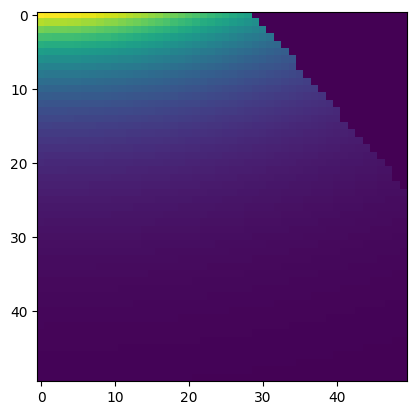

In [52]:
plt.imshow(psi.T)

### TERMA calculation

$$TERMA(r) =  \frac{\mu}{\rho}(E, r)Ψ(E,r) $$

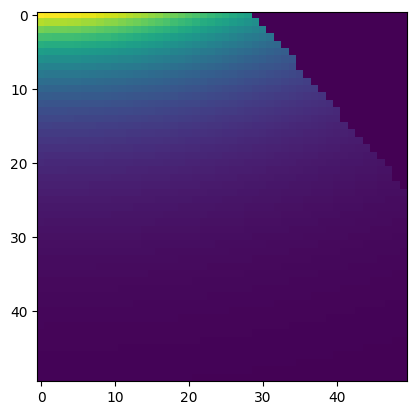

In [53]:
terma = psi * medium

plt.imshow(terma.T)

### Convolve with kernel

$$TERMA * Kernel = Dose$$

In [54]:
import scipy.signal as signal

In [55]:
# generate gaussian kernel

# create kernel
# kernel shape
kernel_shape = np.ceil(20/medium_spacing).astype(int)

start = -5
stop = 5
kernel_size = 21

x, y = np.meshgrid(np.linspace(start,stop,kernel_size), np.linspace(start,stop,kernel_size))
d = np.sqrt(x*x+y*y)
sigma, mu = 1.0, 0.0
kernel = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )

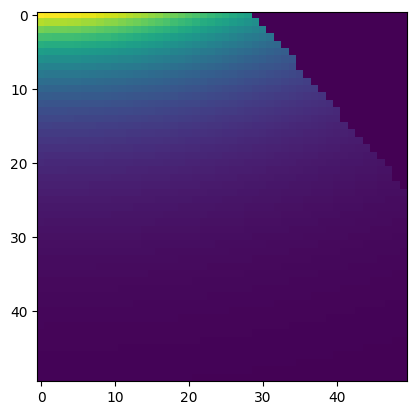

In [56]:
plt.imshow(terma.T)

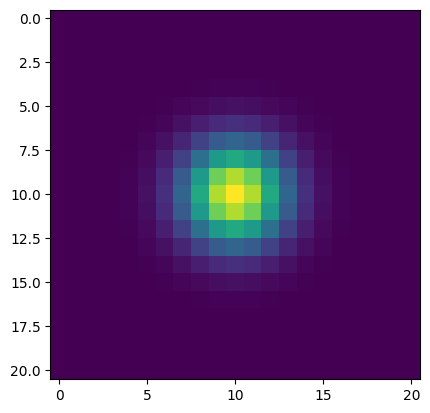

In [57]:
plt.imshow(kernel)

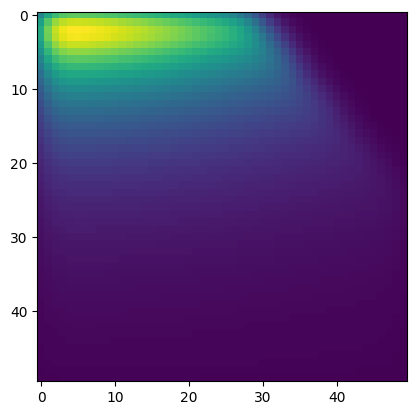

In [58]:
result = signal.convolve2d(terma, kernel)

remove_pad = int((kernel_size-1)/2)
result = result[remove_pad:-remove_pad, remove_pad:-remove_pad]
plt.imshow(result.T)

#### No kernel Stretching (Homogeneous density)

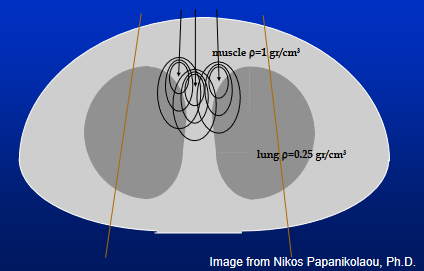

#### Kernel stretching (Heterogeneous density)

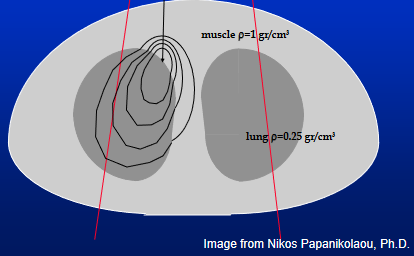

### Manually convolve


อาจจะต้องเขียน convolution เองเนื่องจาก kernel ต่างกันออกไปในแต่ละจุด

Convolution animation: https://medium.com/theleanprogrammer/2-dimensional-convolution-189abb174d92

In [59]:

# pad terma เพื่อ covolution
terma_pad = np.pad(terma, (remove_pad, remove_pad), 'constant', constant_values=0)

In [60]:
def get_kernel(x, y):
    return kernel

new_result = []
for x in range(terma_pad.shape[0]-kernel.shape[0]):
    for y in range(terma_pad.shape[1]- kernel.shape[1]):
        terma_use = terma_pad[x:x+kernel.shape[0], y:y+kernel.shape[1]]

        local_kernel = get_kernel(x, y)
        dose = np.sum(terma_use * local_kernel)
        new_result.append(dose)

In [61]:
new_result = np.array(new_result)
new_result = new_result.reshape((terma_pad.shape[0]- kernel.shape[0], terma_pad.shape[1]-kernel.shape[1]))

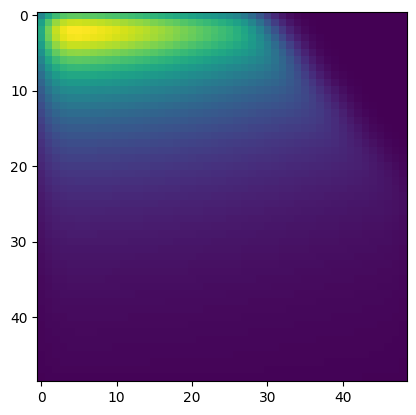

In [62]:
plt.imshow(new_result.T)